In [50]:
!pip install -qq tensorflow-datasets tensorflow matplotlib

In [51]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [52]:
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

In [53]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/martin/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

2023-11-19 14:49:43.180747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-11-19 14:49:43.181127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-19 14:49:43.221375: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

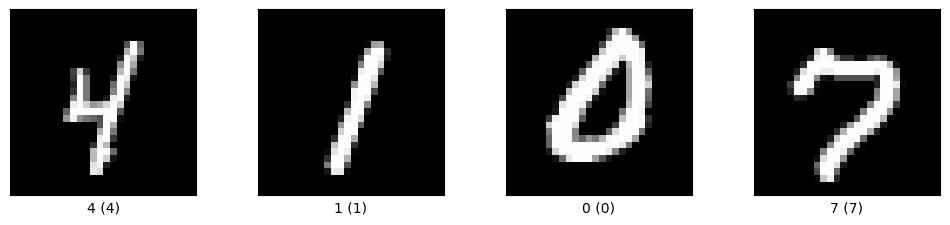

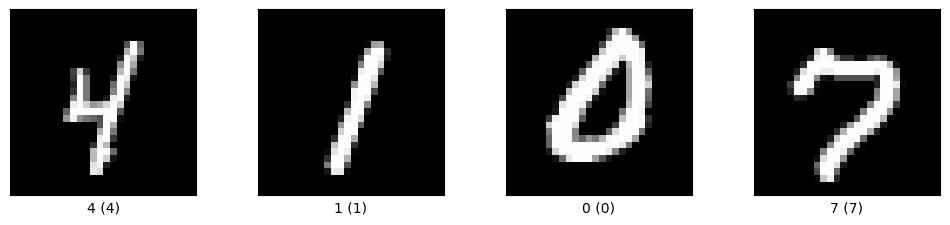

In [54]:
tfds.show_examples(train_ds, ds_info, rows=1, cols=4)

In [55]:
def dataset(ds):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 128.0 - 1, y))
    ds = ds.map(lambda x, y: (tf.reshape(x, (-1,)), y))
    ds = ds.map(lambda x, y: (x, tf.one_hot(y, 10)))
    ds = ds.shuffle(10000).batch(512)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

ds = dataset(train_ds)
for elem in ds.take(1):
    print(elem)

2023-11-19 14:49:43.474033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-19 14:49:43.474417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


(<tf.Tensor: shape=(512, 784), dtype=float32, numpy=
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)>, <tf.Tensor: shape=(512, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)


2023-11-19 14:49:43.829663: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [56]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

In [57]:
from tqdm import tqdm

def training_loop(model, train, test, loss, opt, epochs=100):
    train_loss = tf.keras.metrics.Mean()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_loss = tf.keras.metrics.Mean()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()

    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }

    for epoch in tqdm(range(epochs), desc='Epochs'):
        for x, y in train:
            with tf.GradientTape() as tape:
                y_pred = model(x)
                loss_value = loss(y, y_pred)
            grads = tape.gradient(loss_value, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))
            
            train_loss(loss_value)
            train_accuracy(y, y_pred)
        
        for x, y in test:
            y_pred = model(x)
            loss_value = loss(y, y_pred)
            
            test_loss(loss_value)
            test_accuracy(y, y_pred)

        metrics['train_loss'].append(train_loss.result().numpy())
        metrics['train_accuracy'].append(train_accuracy.result().numpy())
        metrics['test_loss'].append(test_loss.result().numpy())
        metrics['test_accuracy'].append(test_accuracy.result().numpy())

        print(f'Train Loss: {metrics["train_loss"][-1]:.4f}, Train Accuracy: {metrics["train_accuracy"][-1]:.4f}')
        print(f'Test Loss: {metrics["test_loss"][-1]:.4f}, Test Accuracy: {metrics["test_accuracy"][-1]:.4f}')
        print()
    
    return metrics


In [58]:
import matplotlib.pyplot as plt

def visualize(metrics, max_steps=20):

    epoch_idx = range(len(metrics['test_loss']))
    x_ticks = list(range(len(metrics['test_loss'])))
    x_ticks = x_ticks[::len(x_ticks)//max_steps + 1]

    # Create a figure with two subplots (axes)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    def plot_axis(ax, data, label, line_style):
        ax.plot(epoch_idx, data, color)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(label)
        ax.set_xticks(x_ticks)
        ax.grid(True)

    # Plot test loss and accuracy
    line3, = ax1.plot(metrics['test_loss'], 'r-')
    line4, = ax1.plot(metrics['test_accuracy'], 'r--')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend([line3, line4], ['Test Loss', 'Test Accuracy'])
    ax1.set_title('Test Loss and Accuracy')
    ax1.set_xticks(x_ticks)
    ax1.grid(True)

    # Plot training loss and accuracy
    line1, = ax2.plot(metrics['train_loss'], 'b-')
    line2, = ax2.plot(metrics['train_accuracy'], 'b--')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend([line1, line2], ['Train Loss', 'Train Accuracy'])
    ax2.set_title('Training Loss and Accuracy')
    ax2.set_xticks(x_ticks)
    ax2.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]2023-11-19 14:49:43.932540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-11-19 14:49:43.932977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-11-19 14:49:46.349139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholde

Train Loss: 0.8615, Train Accuracy: 0.7398
Test Loss: 0.5470, Test Accuracy: 0.8081



Epochs:  20%|██        | 2/10 [00:05<00:20,  2.54s/it]

Train Loss: 0.6045, Train Accuracy: 0.8180
Test Loss: 0.4325, Test Accuracy: 0.8561



Epochs:  30%|███       | 3/10 [00:07<00:16,  2.34s/it]

Train Loss: 0.4958, Train Accuracy: 0.8516
Test Loss: 0.3869, Test Accuracy: 0.8758



Epochs:  40%|████      | 4/10 [00:09<00:13,  2.25s/it]

Train Loss: 0.4334, Train Accuracy: 0.8709
Test Loss: 0.3601, Test Accuracy: 0.8847



Epochs:  50%|█████     | 5/10 [00:11<00:11,  2.20s/it]

Train Loss: 0.3909, Train Accuracy: 0.8839
Test Loss: 0.3382, Test Accuracy: 0.8919



Epochs:  60%|██████    | 6/10 [00:13<00:08,  2.17s/it]

Train Loss: 0.3592, Train Accuracy: 0.8936
Test Loss: 0.3202, Test Accuracy: 0.8992



Epochs:  70%|███████   | 7/10 [00:15<00:06,  2.20s/it]

Train Loss: 0.3343, Train Accuracy: 0.9012
Test Loss: 0.3024, Test Accuracy: 0.9051



Epochs:  80%|████████  | 8/10 [00:18<00:04,  2.24s/it]

Train Loss: 0.3142, Train Accuracy: 0.9074
Test Loss: 0.2872, Test Accuracy: 0.9102



Epochs:  90%|█████████ | 9/10 [00:20<00:02,  2.25s/it]

Train Loss: 0.2972, Train Accuracy: 0.9125
Test Loss: 0.2747, Test Accuracy: 0.9144



Epochs: 100%|██████████| 10/10 [00:22<00:00,  2.29s/it]

Train Loss: 0.2827, Train Accuracy: 0.9169
Test Loss: 0.2624, Test Accuracy: 0.9187



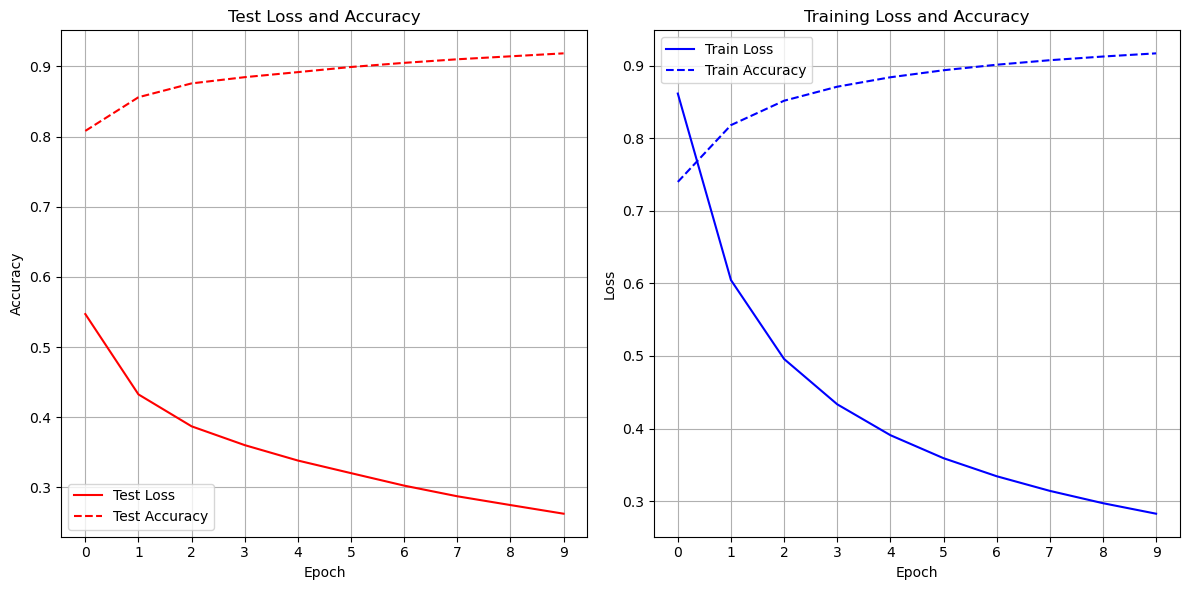

In [59]:
model = Model()
loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate=0.1)

metrics = training_loop(model, dataset(train_ds), dataset(test_ds), loss, opt, 10)
visualize(metrics)

### Hyperparameters

In [60]:
class ModelHyper(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ])

    def call(self, inputs):
        return self.seq(inputs)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

2023-11-19 14:50:07.445553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-11-19 14:50:07.446408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-11-19 14:50:09.861404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{n

Train Loss: 0.5808, Train Accuracy: 0.8283
Test Loss: 0.3207, Test Accuracy: 0.9053



Epochs:  10%|█         | 2/20 [00:05<00:49,  2.76s/it]

Train Loss: 0.4405, Train Accuracy: 0.8702
Test Loss: 0.2907, Test Accuracy: 0.9151



Epochs:  15%|█▌        | 3/20 [00:08<00:48,  2.84s/it]

Train Loss: 0.3757, Train Accuracy: 0.8897
Test Loss: 0.2670, Test Accuracy: 0.9225



Epochs:  20%|██        | 4/20 [00:11<00:44,  2.80s/it]

Train Loss: 0.3338, Train Accuracy: 0.9023
Test Loss: 0.2475, Test Accuracy: 0.9281



Epochs:  25%|██▌       | 5/20 [00:13<00:41,  2.74s/it]

Train Loss: 0.3029, Train Accuracy: 0.9114
Test Loss: 0.2320, Test Accuracy: 0.9329



Epochs:  30%|███       | 6/20 [00:16<00:38,  2.72s/it]

Train Loss: 0.2784, Train Accuracy: 0.9188
Test Loss: 0.2184, Test Accuracy: 0.9374



Epochs:  35%|███▌      | 7/20 [00:19<00:35,  2.74s/it]

Train Loss: 0.2581, Train Accuracy: 0.9249
Test Loss: 0.2071, Test Accuracy: 0.9407



Epochs:  40%|████      | 8/20 [00:22<00:33,  2.77s/it]

Train Loss: 0.2411, Train Accuracy: 0.9299
Test Loss: 0.1965, Test Accuracy: 0.9438



Epochs:  45%|████▌     | 9/20 [00:24<00:30,  2.80s/it]

Train Loss: 0.2267, Train Accuracy: 0.9342
Test Loss: 0.1877, Test Accuracy: 0.9462



Epochs:  50%|█████     | 10/20 [00:27<00:27,  2.73s/it]

Train Loss: 0.2141, Train Accuracy: 0.9378
Test Loss: 0.1800, Test Accuracy: 0.9484



Epochs:  55%|█████▌    | 11/20 [00:30<00:24,  2.69s/it]

Train Loss: 0.2029, Train Accuracy: 0.9412
Test Loss: 0.1732, Test Accuracy: 0.9502



Epochs:  60%|██████    | 12/20 [00:32<00:21,  2.66s/it]

Train Loss: 0.1930, Train Accuracy: 0.9441
Test Loss: 0.1669, Test Accuracy: 0.9519



Epochs:  65%|██████▌   | 13/20 [00:35<00:18,  2.66s/it]

Train Loss: 0.1840, Train Accuracy: 0.9467
Test Loss: 0.1613, Test Accuracy: 0.9535



Epochs:  70%|███████   | 14/20 [00:37<00:15,  2.62s/it]

Train Loss: 0.1760, Train Accuracy: 0.9491
Test Loss: 0.1563, Test Accuracy: 0.9548



Epochs:  75%|███████▌  | 15/20 [00:40<00:12,  2.60s/it]

Train Loss: 0.1686, Train Accuracy: 0.9512
Test Loss: 0.1521, Test Accuracy: 0.9559



Epochs:  80%|████████  | 16/20 [00:43<00:10,  2.58s/it]

Train Loss: 0.1620, Train Accuracy: 0.9531
Test Loss: 0.1478, Test Accuracy: 0.9571



Epochs:  85%|████████▌ | 17/20 [00:45<00:07,  2.57s/it]

Train Loss: 0.1559, Train Accuracy: 0.9549
Test Loss: 0.1443, Test Accuracy: 0.9580



Epochs:  90%|█████████ | 18/20 [00:48<00:05,  2.57s/it]

Train Loss: 0.1503, Train Accuracy: 0.9565
Test Loss: 0.1413, Test Accuracy: 0.9587



Epochs:  95%|█████████▌| 19/20 [00:50<00:02,  2.59s/it]

Train Loss: 0.1452, Train Accuracy: 0.9580
Test Loss: 0.1382, Test Accuracy: 0.9596



Epochs: 100%|██████████| 20/20 [00:53<00:00,  2.68s/it]

Train Loss: 0.1403, Train Accuracy: 0.9594
Test Loss: 0.1354, Test Accuracy: 0.9603



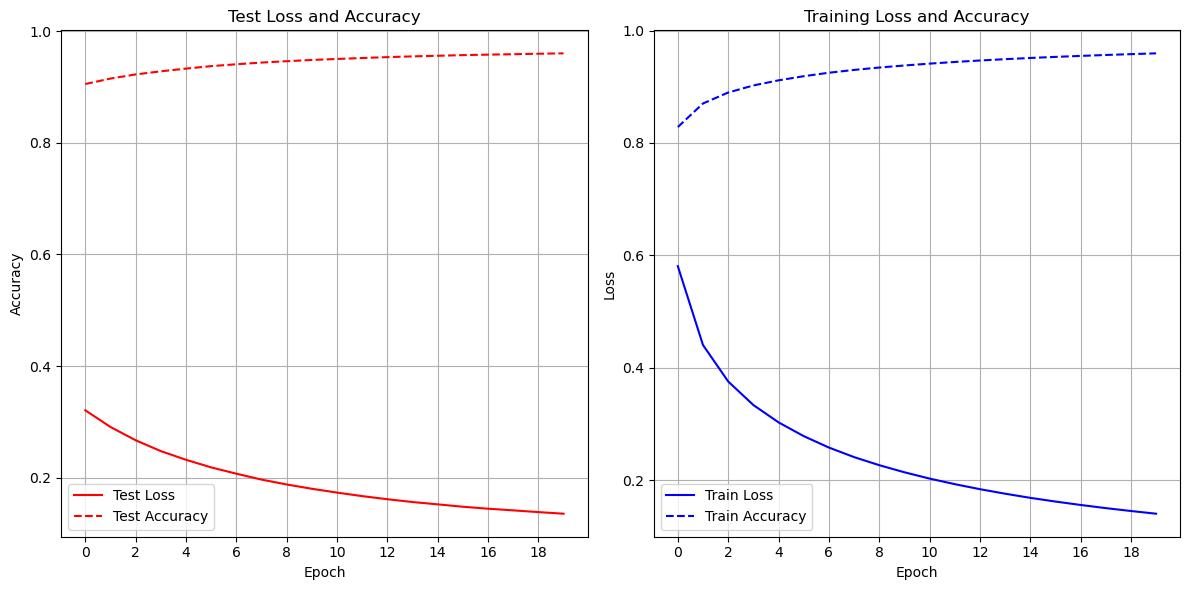

In [61]:
model = Model()
loss = tf.keras.losses.CategoricalCrossentropy()
epochs = 20
lr_fn = tf.optimizers.schedules.PolynomialDecay(1e-2, epochs, 1e-4, 2)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

metrics = training_loop(model, dataset(train_ds), dataset(test_ds), loss, opt, epochs)
visualize(metrics)